In [127]:
%load_ext autoreload
%autoreload 2
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from dnafiber.deployment import ENSEMBLE, Models, run_one_file
from dnafiber.inference import _get_model

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True

# Deactivate pandas FutureWarning
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
Models.UNET_MOBILEONE_S0

<Models.UNET_MOBILEONE_S0: 'unet_mobileone_s0'>

In [129]:
root = Path("/home/clement/Documents/data/DNAFiber/Input/")
output = Path("/home/clement/Documents/data/DNAFiber/OutputEnsembleV2/")
output.mkdir(exist_ok=True, parents=True) 
all_files = list(root.rglob("*.czi"))
for file in tqdm(all_files, total=len(all_files)):
    path_from_input = file.relative_to(root)
    output_file = output / path_from_input.with_suffix(".csv")
    if output_file.exists():
        continue  # Skip if the output file already exists
    df = run_one_file(file, model=ENSEMBLE, verbose=True, use_tta=False).to_df(img_name=file.stem, filter_invalid=False)
    output_file.parent.mkdir(exist_ok=True, parents=True)
    df.to_csv(output_file, index=False)

100%|██████████| 248/248 [00:00<00:00, 22131.65it/s]


In [130]:

palette = ["#81c8be", "#ef9f76"]

In [131]:
import matplotlib.pyplot as plt
from experiments import exp1, exp2, exp3, exp4, exp5

root = Path("/home/clement/Documents/data/DNAFiber/OutputEnsembleV2/YM-2025-20/")


df1, pairs1 = exp1("OutputEnsembleV2/YM-2025-20/", "YM-2025-20.xlsx")
df2, pairs2 = exp2("OutputEnsembleV2/YM-2025-16/", "YM-2025-16.xlsx")
df3, pairs3 = exp3("OutputEnsembleV2/YM-2025-17/", "YM-2025-17.xlsx")
df4, pairs4 = exp4("OutputEnsembleV2/YM-2025-21-22/", ["YM-2025-21.xlsx", "YM-2025-22.xlsx"])
df5, pairs5 = exp5("OutputEnsembleV2/YM-2025-25/", "YM-2025-25.xlsx")

['siBRCA2_12.5' 'si53BP1_5' 'siNT' 'si53BP1_7.5' 'siBRCA2_7.5'
 'si53BP1_12.5' 'siBRCA2_5']


TypeError: dnafiber.analysis.ratios.create_boxen_plot() got multiple values for keyword argument 'alpha'

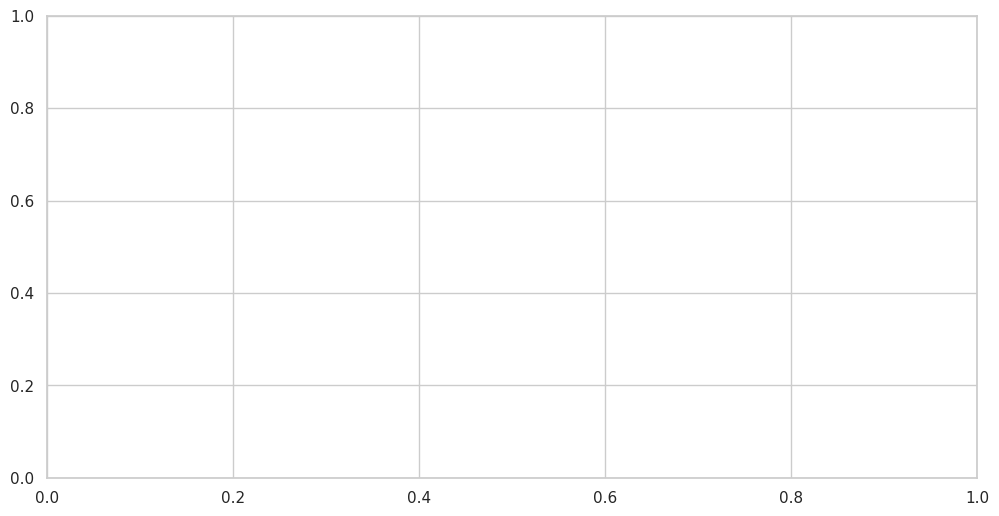

In [132]:
import string

from dnafiber.analysis.ratios import (
    compare_pairs,
    create_boxen_plot,
    create_boxen_swarmplot,
    normalize_df,
    select_N_closest_to_mean,
    select_N_closest_to_median,
)

df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
fig, ax = plt.subplots(figsize=(12, 6))


normalize_df(df, 'siNT')
# Relabel the type to anonymous labels (e.g., 'A', 'B', 'C' etc.)
alphabet = list(string.ascii_uppercase) + [a + b for a in string.ascii_uppercase for b in string.ascii_lowercase]




# Reorder the 'Type' categories based on the median 'Ratio' values
type_order = df.groupby('Type')['Ratio'].median().sort_values().index
df['Type'] = pd.Categorical(df['Type'], categories=type_order, ordered=True)
type_mapping = {original_type: f"Exp {alphabet[i]}" for i, original_type in enumerate((df['Type'].cat.categories)) if original_type != 'siNT'}
type_mapping['siNT'] = 'siNT'
df['Type'] = df['Type'].map(type_mapping)
create_boxen_swarmplot(
    df,
    palette=palette,
    rotate_xticks=45,
    yrange=(0.125, 8),
    stripplot=True,
    alpha=0.75,
    dodge=True,
    size=2,
    jitter=0.3
)

# Change the color of the siNT xtick label to red
xticks = plt.gca().get_xticklabels()
for xtick in xticks:
    if xtick.get_text() == 'siNT':
        xtick.set_color('red')
        xtick.set_fontweight('bold')

# Remove the alpha from the legend markers
handles, labels = plt.gca().get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(1)
    # Increase the size of the legend markers
    if hasattr(handle, "set_sizes"):
        handle.set_sizes([10])
    elif hasattr(handle, "set_markersize"):
        handle.set_markersize(10)
plt.legend(handles, labels, title="Grader", loc='upper left')
plt.ylabel("Ratio (CldU/IdU)")
plt.savefig("figures/boxen_swarmplot_all.png", dpi=300, bbox_inches='tight')
plt.show()

# df_select = select_N_closest_to_mean(df, N=None, column="Length")
df_select = select_N_closest_to_median(df, N=None, column="Length")
plt.figure(figsize=(12, 6))

create_boxen_swarmplot(
    df_select,
    palette=palette,
    rotate_xticks=45,
    yrange=(0.125, 8),
    stripplot=True,
    alpha=0.75,
    dodge=True,
    size=2,
    jitter=0.3
)
# Change the color of the siNT xtick label to red
xticks = plt.gca().get_xticklabels()
for xtick in xticks:
    if xtick.get_text() == 'siNT':
        xtick.set_color('red')
        xtick.set_fontweight('bold')


plt.ylabel("Ratio (CldU/IdU)")
plt.savefig("figures/boxen_swarmplot_all_selected.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df.groupby(['Type', 'Grader'])['Ratio'].median().unstack()

Grader,Human,AI
Type,,
Exp A,0.870610,1.000000
Exp B,0.817219,1.000000
Exp C,0.925407,1.007194
Exp D,1.050790,1.111111
Exp E,1.068784,1.154420
Exp F,1.122013,1.176263
Exp G,0.945295,1.220000
Exp H,1.129664,1.205745
Exp I,1.176156,1.205882


/tmp/ipykernel_525347/762308418.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_sint_sibrca1['Type'] = df1_sint_sibrca1['Type'].cat.remove_unused_categories()


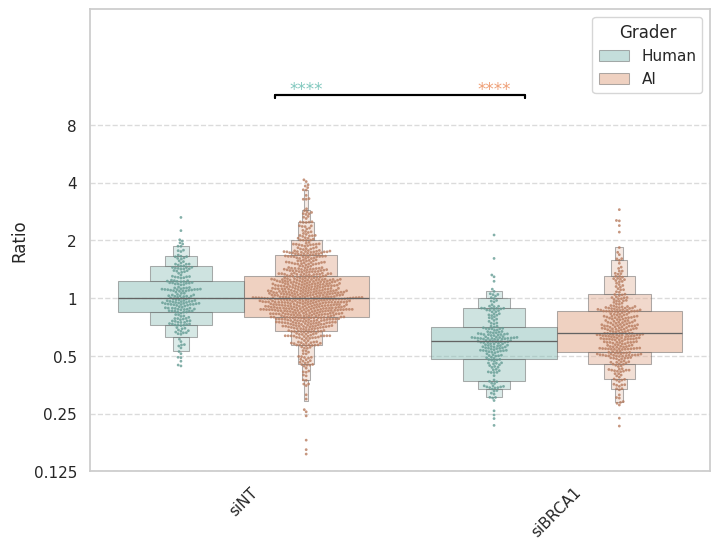

In [158]:
df1_sint_sibrca1 = df1[
	(df1['Ratio'] < 8) &
	(df1['Ratio'] > 0.125) &
	(df1['Valid']) &
	(df1['Type'].isin(['siNT', 'siBRCA1']))
]

df1_sint_sibrca1['Type'] = df1_sint_sibrca1['Type'].cat.remove_unused_categories()
plt.figure(figsize=(8, 6)) 
normalize_df(df1_sint_sibrca1, 'siNT')
create_boxen_swarmplot(df1_sint_sibrca1, palette=palette, dodge=True, size=2)
# graders_statistical_test(df1_sint_sibrca1)
compare_pairs(df1_sint_sibrca1, palette=palette, pairs=[('siNT', 'siBRCA1', 5)])
plt.savefig("figures/boxen_swarmplot_siNT_siBRCA1.png", dpi=300, bbox_inches='tight')
plt.show()


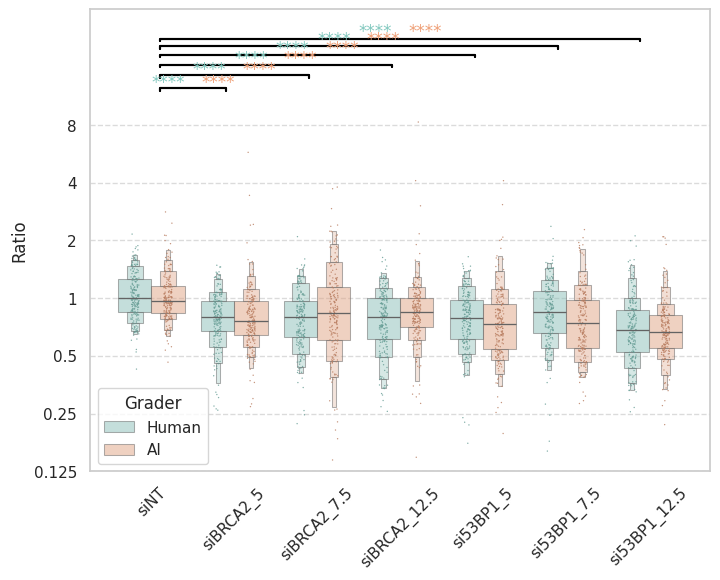

In [ ]:
df5_sint_sibrca1 = df5[df5['Ratio'] < 8]
df5_sint_sibrca1 = df5[df5['Ratio'] > 0.125]

df5_sint_sibrca1 = df5[df5['Valid']]
normalize_df(df5_sint_sibrca1, 'siNT')
df5_sint_sibrca1 = select_N_closest_to_median(df5_sint_sibrca1, N=None, column="Length")
plt.figure(figsize=(8, 6)) 

create_boxen_swarmplot(df5_sint_sibrca1, palette=palette, dodge=True, size=1, stripplot=True)
# graders_statistical_test(df5_sint_sibrca1)
pairs = [('siNT', p2, 4+2**i) for i, p2 in enumerate(df5_sint_sibrca1['Type'].unique()) if p2 != 'siNT']
compare_pairs(df5_sint_sibrca1, palette=palette, pairs=pairs)

plt.savefig("figures/boxen_swarmplot_exp5.png", dpi=300, bbox_inches='tight')
plt.show()

In [167]:
pairs

[('siNT', 'siBRCA2_5', 5),
 ('siNT', 'siBRCA2_7.5', 6),
 ('siNT', 'siBRCA2_12.5', 7),
 ('siNT', 'si53BP1_5', 8),
 ('siNT', 'si53BP1_7.5', 9),
 ('siNT', 'si53BP1_12.5', 10)]

/tmp/ipykernel_525347/3294549848.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


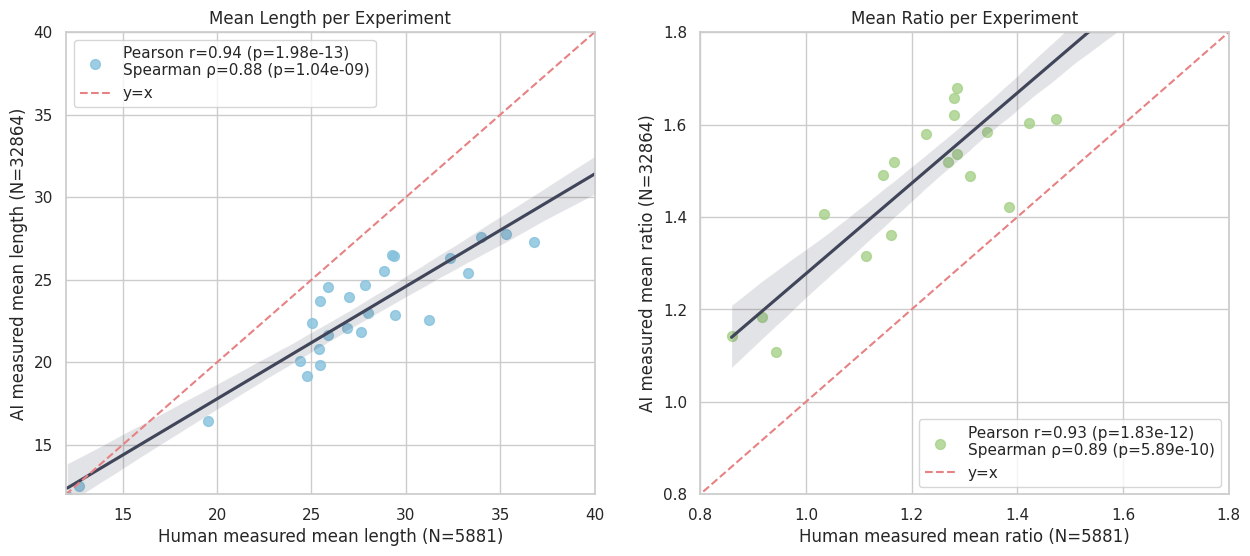

In [ ]:
from scipy.stats import pearsonr, spearmanr
df_select = select_N_closest_to_median(df, N=None, column="Ratio")

x = df[df["Grader"] == "Human"]
y = df[df["Grader"] == "AI"]

# x = df_select[df_select["Grader"] == "Human"]
# y = df_select[df_select["Grader"] == "AI"]
grouped_x = x.groupby("Type")
grouped_y = y.groupby("Type")
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (measure, yrange, color) in enumerate([("Length", (12, 40), "#85c1dc"), ("Ratio", (0.8, 1.8), "#a6d189")]):
    rho = pearsonr(grouped_x[f"{measure}"].mean(), grouped_y[f"{measure}"].mean())
    phi = spearmanr(grouped_x[f"{measure}"].mean(), grouped_y[f"{measure}"].mean())
    sns.regplot(x=grouped_x[f"{measure}"].mean(), y=grouped_y[f"{measure}"].mean(), 
                scatter_kws={"s": 50}, 
                line_kws={"color": "#414559"},
                color=color,
                label=f"Pearson r={rho[0]:.2f} (p={rho[1]:.2e})\nSpearman ρ={phi[0]:.2f} (p={phi[1]:.2e})",
                ax=axes[i])
    axes[i].set_xlabel(f"Human measured mean {measure.lower()} (N={len(x)})")
    axes[i].set_ylabel(f"AI measured mean {measure.lower()} (N={len(y)})")

    axes[i].set_title(f"Mean {measure} per Experiment")
    axes[i].plot([0, 40], [0, 40], color="#e78284", linestyle="--", label="y=x")
    axes[i].legend()

    axes[i].set_ylim(yrange)
    axes[i].set_xlim(yrange)

fig.show()
fig.savefig("figures/ai_vs_human_length_ratio.png", dpi=300)

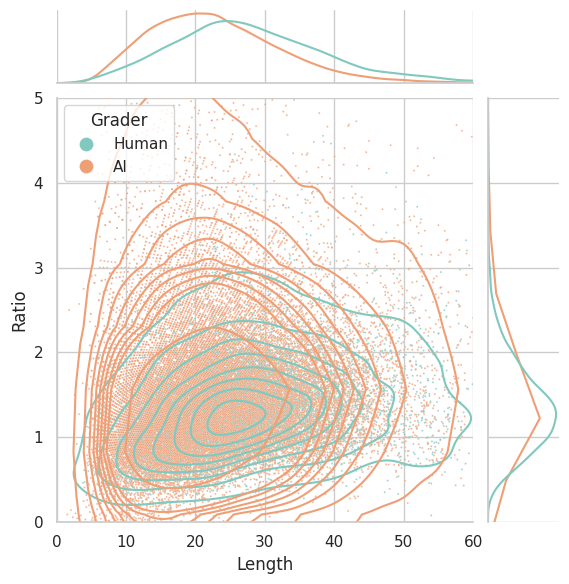

In [ ]:
palette = ["#81c8be", "#ef9f76"]
g = sns.jointplot(data=df, 
                  x="Length", y="Ratio", 
                  hue="Grader",

                  kind="kde",
                  palette=palette, marginal_kws={"common_norm": False})
                #   common_norm=False, fill=True, multiple="stack", common_grid=True,)
g.plot_joint(sns.scatterplot, s=2, alpha=0.75)
# Change the size and alpha of the legend markers

handles, labels = plt.gca().get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(1)
    # Increase the size of the legend markers
    if hasattr(handle, "set_sizes"):
        handle.set_sizes([10])
    elif hasattr(handle, "set_markersize"):
        handle.set_markersize(10)
plt.legend(handles, labels, title="Grader", loc='upper left')

plt.xlim(0, 60)
plt.ylim(0, 5)
plt.savefig("figures/length_vs_ratio_kde.png", dpi=300)

In [ ]:
#